
### 05 — AutoEncoder for Collaborative Filtering
Train a denoising autoencoder on the user–movie rating matrix to learn dense representations and produce recommendations.


In [1]:
from pathlib import Path
import sys

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import display

BASE = Path.cwd() if Path.cwd().name != 'notebooks' else Path.cwd().parent
if str(BASE) not in sys.path:
    sys.path.append(str(BASE))
if str(BASE / 'src') not in sys.path:
    sys.path.append(str(BASE / 'src'))

from src.autoencoder_model import (
    encode_dense_splits,
    AutoEncoderDataset,
    build_autoencoder,
    run_epoch,
    build_seen_items,
    recommend_topk,
)

PROC = BASE / 'data' / 'processed'
MODELS = BASE / 'models'
MODELS.mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


In [2]:

train_df = pd.read_csv(PROC / "ratings_train.csv")
valid_df = pd.read_csv(PROC / "ratings_valid.csv")
test_df  = pd.read_csv(PROC / "ratings_test.csv")

for name, df in [("train", train_df), ("valid", valid_df), ("test", test_df)]:
    print(f"{name:>5} -> shape={df.shape}  users={df.userId.nunique()}  items={df.movieId.nunique()}")


train -> shape=(31316, 7)  users=479  items=426
valid -> shape=(3669, 7)  users=479  items=426
 test -> shape=(3669, 7)  users=479  items=426


In [3]:
train_mat, train_mask, valid_mat, valid_mask, test_mat, test_mask, user2idx, item2idx = encode_dense_splits(train_df, valid_df, test_df)
print('Matrix shape:', train_mat.shape, 'train density:', round(float(train_mask.mean()), 4))


Matrix shape: (479, 426) train density: 0.1535


In [4]:
BATCH_SIZE = 64
train_loader = DataLoader(AutoEncoderDataset(train_mat, train_mask), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(AutoEncoderDataset(valid_mat, valid_mask), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(AutoEncoderDataset(test_mat, test_mask), batch_size=BATCH_SIZE, shuffle=False)


In [5]:
model = build_autoencoder(n_items=train_mat.shape[1], hidden_dims=(512, 256, 128), dropout=0.25, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [6]:
EPOCHS = 40
history = {'train_rmse': [], 'valid_rmse': [], 'valid_mae': []}

best_rmse = float('inf')
best_epoch = None
model_path = MODELS / 'autoencoder_best.pth'

for epoch in range(1, EPOCHS + 1):
    train_metrics = run_epoch(model, train_loader, optimizer=optimizer, device=device)
    val_metrics = run_epoch(model, valid_loader, optimizer=None, device=device)

    history['train_rmse'].append(train_metrics.rmse)
    history['valid_rmse'].append(val_metrics.rmse)
    history['valid_mae'].append(val_metrics.mae)

    print(f"Epoch {epoch:02d} | train RMSE={train_metrics.rmse:.4f}  valid RMSE={val_metrics.rmse:.4f}  valid MAE={val_metrics.mae:.4f}")

    if val_metrics.rmse < best_rmse:
        best_rmse = val_metrics.rmse
        best_epoch = epoch
        torch.save({'state_dict': model.state_dict()}, model_path)

print('Best validation RMSE:', best_rmse, 'at epoch', best_epoch)


Epoch 01 | train RMSE=2.7385  valid RMSE=2.1027  valid MAE=1.7228
Epoch 02 | train RMSE=1.8565  valid RMSE=1.7423  valid MAE=1.3990
Epoch 03 | train RMSE=1.7405  valid RMSE=1.7520  valid MAE=1.4105
Epoch 04 | train RMSE=1.7226  valid RMSE=1.7585  valid MAE=1.4170
Epoch 05 | train RMSE=1.7040  valid RMSE=1.7478  valid MAE=1.4096
Epoch 06 | train RMSE=1.6840  valid RMSE=1.7428  valid MAE=1.4047
Epoch 07 | train RMSE=1.6776  valid RMSE=1.7402  valid MAE=1.4031
Epoch 08 | train RMSE=1.6714  valid RMSE=1.7385  valid MAE=1.4006
Epoch 09 | train RMSE=1.6597  valid RMSE=1.7405  valid MAE=1.4032
Epoch 10 | train RMSE=1.6607  valid RMSE=1.7405  valid MAE=1.4032
Epoch 11 | train RMSE=1.6603  valid RMSE=1.7342  valid MAE=1.3988
Epoch 12 | train RMSE=1.6579  valid RMSE=1.7358  valid MAE=1.3997
Epoch 13 | train RMSE=1.6593  valid RMSE=1.7364  valid MAE=1.4003
Epoch 14 | train RMSE=1.6596  valid RMSE=1.7363  valid MAE=1.4001
Epoch 15 | train RMSE=1.6596  valid RMSE=1.7363  valid MAE=1.4000
Epoch 16 |

In [7]:
EPOCHS = 80
PATIENCE = 8
best_val_rmse = float('inf')
best_epoch = 0
wait = 0

history = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_mae': []}
checkpoint_path = MODELS / 'autoencoder_best.pth'

for epoch in range(1, EPOCHS + 1):
    train_metrics = run_epoch(model, train_loader, optimizer=optimizer, device=device)
    val_metrics = run_epoch(model, valid_loader, optimizer=None, device=device)

    history['train_loss'].append(train_metrics.loss)
    history['val_loss'].append(val_metrics.loss)
    history['val_rmse'].append(val_metrics.rmse)
    history['val_mae'].append(val_metrics.mae)

    print(
        f"Epoch {epoch:02d} | train_loss={train_metrics.loss:.4f} | "
        f"val_loss={val_metrics.loss:.4f} | val_RMSE={val_metrics.rmse:.4f} | val_MAE={val_metrics.mae:.4f}"
    )

    if val_metrics.rmse + 1e-4 < best_val_rmse:
        best_val_rmse = val_metrics.rmse
        best_epoch = epoch
        wait = 0
        torch.save(
            {
                'state_dict': model.state_dict(),
                'user2idx': user2idx.to_dict(),
                'item2idx': item2idx.to_dict(),
                'history': history,
                'best_val_rmse': best_val_rmse,
            },
            checkpoint_path,
        )
    else:
        wait += 1
        if wait >= PATIENCE:
            print('Early stopping triggered.')
            break

print(f"Best validation RMSE {best_val_rmse:.4f} at epoch {best_epoch}")


Epoch 01 | train_loss=2.7558 | val_loss=3.1340 | val_RMSE=1.7402 | val_MAE=1.4031
Epoch 02 | train_loss=2.7466 | val_loss=3.1340 | val_RMSE=1.7402 | val_MAE=1.4031
Epoch 03 | train_loss=2.7374 | val_loss=3.1340 | val_RMSE=1.7402 | val_MAE=1.4031
Epoch 04 | train_loss=2.7482 | val_loss=3.1340 | val_RMSE=1.7402 | val_MAE=1.4031
Epoch 05 | train_loss=2.7750 | val_loss=3.1340 | val_RMSE=1.7402 | val_MAE=1.4031
Epoch 06 | train_loss=2.7567 | val_loss=3.1340 | val_RMSE=1.7402 | val_MAE=1.4031
Epoch 07 | train_loss=2.7406 | val_loss=3.1340 | val_RMSE=1.7402 | val_MAE=1.4031
Epoch 08 | train_loss=2.7458 | val_loss=3.1340 | val_RMSE=1.7402 | val_MAE=1.4031
Epoch 09 | train_loss=2.7039 | val_loss=3.1340 | val_RMSE=1.7402 | val_MAE=1.4031
Early stopping triggered.
Best validation RMSE 1.7402 at epoch 1


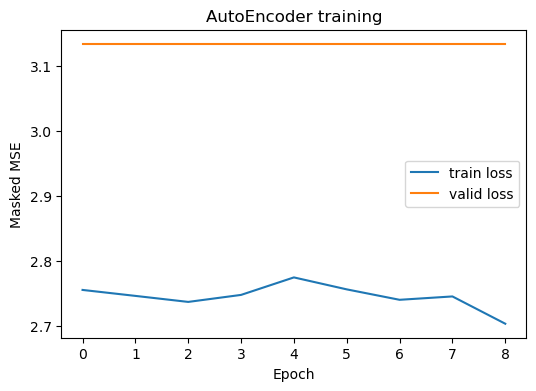

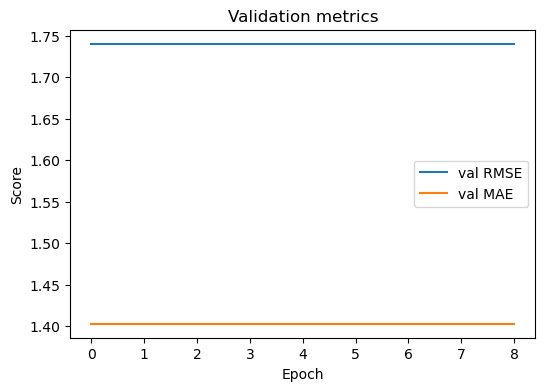

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.xlabel('Epoch')
plt.ylabel('Masked MSE')
plt.legend()
plt.title('AutoEncoder training')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history['val_rmse'], label='val RMSE')
plt.plot(history['val_mae'], label='val MAE')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation metrics')
plt.show()


In [9]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])

test_metrics = run_epoch(model, test_loader, optimizer=None, device=device)
print(f"Test RMSE: {test_metrics.rmse:.4f} | Test MAE: {test_metrics.mae:.4f}")


Test RMSE: 1.7435 | Test MAE: 1.3848


In [10]:
train_seen = build_seen_items(train_df)
movies_meta = pd.read_csv(PROC / 'movies_enriched.csv', usecols=['movieId', 'title', 'genres'])

sample_user = int(train_df['userId'].sample(1, random_state=42).iloc[0])
recs = recommend_topk(
    model,
    sample_user,
    train_matrix=train_mat,
    user2idx=user2idx,
    item2idx=item2idx,
    train_seen=train_seen,
    k=10,
    device=device,
).merge(movies_meta, on='movieId', how='left')

print('Sample user:', sample_user)
display(recs)


Sample user: 591


,movieId,score,title,genres
0,595,5.0,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX
1,4995,5.0,"Beautiful Mind, A (2001)",Drama|Romance
2,4896,5.0,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy
3,5459,5.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
4,5445,5.0,Minority Report (2002),Action|Crime|Mystery|Sci-Fi|Thriller
5,2078,5.0,"Jungle Book, The (1967)",Animation|Children|Comedy|Musical
6,2700,5.0,"South Park: Bigger, Longer and Uncut (1999)",Animation|Comedy|Musical
7,5502,5.0,Signs (2002),Horror|Sci-Fi|Thriller
8,4973,5.0,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
9,4308,5.0,Moulin Rouge (2001),Drama|Musical|Romance
